<a href="https://colab.research.google.com/github/GuilhermeLoboSousa/sistemasinteligentes/blob/main/group1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drug Synergy Prediction

1.   Exploração inical e pré-processamento
2.   Análise não supervisionada




## Group 1
Guilherme Sousa

Joana Araújo

Karyna Lysenko

Tiago Silva

**Exploração inical e pré-processamento**

**Definition**: Synergy is a dimensionless measure of deviation of an observed drug combination response from the expected effect of non-interaction. Synergy can be calculated using different models such as the Bliss model, Highest Single Agent (HSA), Loewe additivity model and Zero Interaction Potency (ZIP). Another relevant metric is CSS which measures the drug combination sensitivity and is derived using relative IC50 values of compounds and the area under their dose-response curves.

**Impact**: Drug combination therapy offers enormous potential for expanding the use of existing drugs and in improving their efficacy. For instance, the simultaneous modulation of multiple targets can address the common mechanisms of drug resistance in the treatment of cancers. However, experimentally exploring the entire space of possible drug combinations is not a feasible task. Computational models that can predict the therapeutic potential of drug combinations can thus be immensely valuable in guiding this exploration.

**Generalization**: It is important for model predictions to be able to adapt to varying underlying biology as captured through different cell lines drawn from multiple tissues of origin. Dosage is also an important factor that can impact model generalizability.

**Product**: Small-molecule.

**Pipeline**: Activity.

Link:https://tdcommons.ai/multi_pred_tasks/drugsyn/

**Dataset Description**: A large-scale oncology screen produced by Merck & Co., where each sample consists of two compounds and a cell line. The dataset covers 583 distinct combinations, each tested against 39 human cancer cell lines derived from 7 different tissue types. Pairwise combinations were constructed from 38 diverse anticancer drugs (14 experimental and 24 approved). The synergy score is calculated by Loewe Additivity values using the batch processing mode of Combenefit. The genomic features are from ArrayExpress database (accession number: E-MTAB-3610) and was quantile normalized and summarized with Factor Analysis for Robust Microarray Summarization (FARMS). The processed data is provided by DeepSynergy.

**Task Description**: Regression. Given the gene expression of cell lines and two SMILES strings of the drug combos, predict the drug synergy level.

**Dataset Statistics**: 23,052 drug combo-cell line points, among 39 cancer cell lines and 37 drugs

# Imports

In [1]:
from tdc.multi_pred import DrugSyn
import pandas as pd

from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import Chem, RDLogger

import numpy as np
from rdkit.Chem.GraphDescriptors import Ipc
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors

from collections import OrderedDict

from rdkit.Chem import AllChem

from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

# Etapa 1

Nesta fase o nosso objetivo foi construir e filtrar o nosso dataset , tendo para isso em atenção que a drug1 e 2 inicialmente nao estavam stander, a info das cell line estava dentro de listas e, que necessitariamos de features como descritores e morgan.

Depois realizamos uma filtragem ao nosso dataset, diminuindo o  numero de features (critério de variancia) e o numero de linhas(removendo outliers).

Guardamos o dataset resultatante num ficheiro csv com o nome datasete.csv

**Carregar o dataset**

In [2]:
data = DrugSyn(name = "OncoPolyPharmacology")
dataset=data.get_data()
dataset

Found local copy...
Loading...
Done!


,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cell_Line,Drug1,Drug2
0,5-FU,ABT-888,A2058,7.693530,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
1,5-FU,ABT-888,A2780,7.778053,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2,5-FU,ABT-888,A375,-1.198505,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
3,5-FU,ABT-888,A427,2.595684,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4,5-FU,ABT-888,CAOV3,-5.139971,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
...,...,...,...,...,...,...,...
23047,ZOLINZA,TOPOTECAN,UACC62,10.223066,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...
23048,ZOLINZA,TOPOTECAN,UWB1289BRCA1,20.551627,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...
23049,ZOLINZA,TOPOTECAN,UWB1289,12.190316,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...
23050,ZOLINZA,TOPOTECAN,VCAP,23.438547,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...


# Explorar o dataset

associar cada cell line id a um determianado tipo de cancro /tecido. e depois verificar se um valor muito elevado de y ou muito baixo estáo associados a algum tipo de cancro.

In [3]:
#verificar as cell lines cancerigenas existentes
cell_lines_cancer = list(OrderedDict.fromkeys(dataset['Cell_Line_ID']))
print(f"Existem {len(cell_lines_cancer)} cujo id é {cell_lines_cancer}")


Existem 39 cujo id é ['A2058', 'A2780', 'A375', 'A427', 'CAOV3', 'COLO320DM', 'DLD1', 'EFM192B', 'ES2', 'HCT116', 'HT144', 'HT29', 'KPL1', 'LNCAP', 'LOVO', 'MDAMB436', 'MSTO', 'NCIH1650', 'NCIH2122', 'NCIH23', 'NCIH460', 'NCIH520', 'OCUBM', 'OV90', 'OVCAR3', 'PA1', 'RKO', 'RPMI7951', 'SKMEL30', 'SKMES1', 'SKOV3', 'SW620', 'SW837', 'T47D', 'UACC62', 'UWB1289BRCA1', 'UWB1289', 'VCAP', 'ZR751']


In [4]:
#adicionar ao nosso data a correspondencia entre cell line id e o respetivo tecido cancerigeno
ids_celulas = ['A2058', 'A2780', 'A375', 'A427', 'CAOV3', 'COLO320DM', 'DLD1', 'EFM192B', 'ES2', 'HCT116', 'HT144', 'HT29', 'KPL1', 'LNCAP', 'LOVO', 'MDAMB436', 'MSTO', 'NCIH1650', 'NCIH2122', 'NCIH23', 'NCIH460', 'NCIH520', 'OCUBM', 'OV90', 'OVCAR3', 'PA1', 'RKO', 'RPMI7951', 'SKMEL30', 'SKMES1', 'SKOV3', 'SW620', 'SW837', 'T47D', 'UACC62', 'UWB1289BRCA1', 'UWB1289', 'VCAP', 'ZR751']

tipos_cancer = ['pele', 'ovario', 'pele', 'pulmao', 'ovario', 'colon', 'colon', 'mama', 'ovario', 'colon', 'pele', 'colon', 'mama', 'prostata', 'colon', 'mama', 'pulmao', 'pulmao', 'pulmao', 'pulmao', 'pulmao', 'mama', 'ovario', 'ovario', 'ovario', 'colon', 'pele', 'pele', 'pulmao', 'ovario', 'colon', 'colon', 'mama', 'pele', 'mama', 'ovario', 'prostata', 'mama', 'ovario']

dicionario_cancer = dict(zip(ids_celulas, tipos_cancer))

dataset['Tipo_Cancer'] = dataset['Cell_Line_ID'].map(dicionario_cancer)
dataset

,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cell_Line,Drug1,Drug2,Tipo_Cancer
0,5-FU,ABT-888,A2058,7.693530,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,pele
1,5-FU,ABT-888,A2780,7.778053,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,ovario
2,5-FU,ABT-888,A375,-1.198505,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,pele
3,5-FU,ABT-888,A427,2.595684,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,pulmao
4,5-FU,ABT-888,CAOV3,-5.139971,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,ovario
...,...,...,...,...,...,...,...,...
23047,ZOLINZA,TOPOTECAN,UACC62,10.223066,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,mama
23048,ZOLINZA,TOPOTECAN,UWB1289BRCA1,20.551627,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,ovario
23049,ZOLINZA,TOPOTECAN,UWB1289,12.190316,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,prostata
23050,ZOLINZA,TOPOTECAN,VCAP,23.438547,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,mama


In [5]:
ordenado_por_y = dataset.sort_values(by='Y')

df_top_10 = ordenado_por_y.tail(10)

df_bottom10 = ordenado_por_y.head(10)


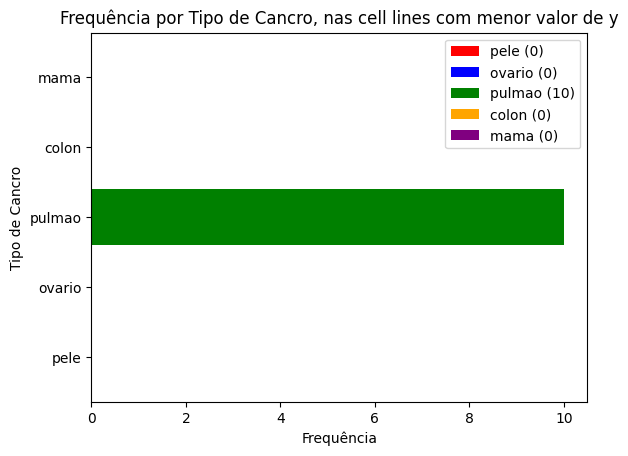

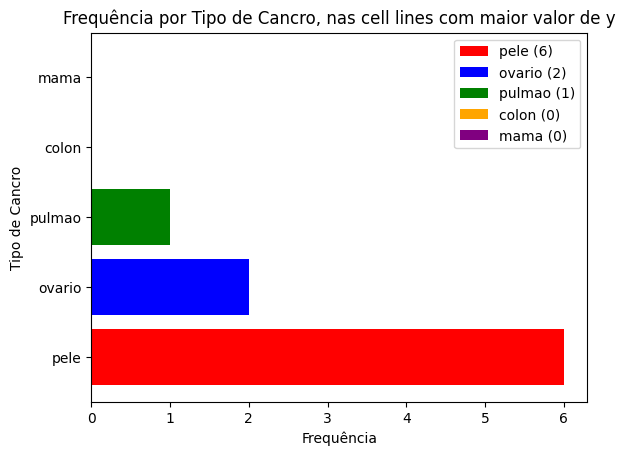

In [6]:
fig, ax = plt.subplots()

for tipo_cancer, cor in zip(dataset['Tipo_Cancer'].unique(), ['red', 'blue', 'green', 'orange', 'purple']):
    df_tipo_cancer = df_bottom10[df_bottom10['Tipo_Cancer'] == tipo_cancer]
    
    freq = len(df_tipo_cancer)
    ax.barh(tipo_cancer, freq, color=cor, label=f'{tipo_cancer} ({freq})')

ax.set_xlabel('Frequência')
ax.set_ylabel('Tipo de Cancro')
ax.set_title('Frequência por Tipo de Cancro, nas cell lines com menor valor de y')

# Adicionar legenda
ax.legend()

# Mostrar o gráfico
plt.show()

fig, ax = plt.subplots()

for tipo_cancer, cor in zip(dataset['Tipo_Cancer'].unique(), ['red', 'blue', 'green', 'orange', 'purple']):
    df_tipo_cancer = df_top_10[df_top_10['Tipo_Cancer'] == tipo_cancer]
    
    freq = len(df_tipo_cancer)
    ax.barh(tipo_cancer, freq, color=cor, label=f'{tipo_cancer} ({freq})')

ax.set_xlabel('Frequência')
ax.set_ylabel('Tipo de Cancro')
ax.set_title('Frequência por Tipo de Cancro, nas cell lines com maior valor de y')

# Adicionar legenda
ax.legend()

# Mostrar o gráfico
plt.show()

Aqui procuramos encontrar se a capacidade de sinergir duas drogas poderia estar relacionada com o tipo de tecido cancerigeno em análise. Verificamos que quando analisamos os 10 valores mais baixos de Y, onde a sinergia é praticamaente nula todos correspondem ao pulmão. Sem mais informações nao podemos retirar uma conclusão imediata, mas pode mostrar a dificuldade existente neste tipo de patologias no local referido de encontrar uma boa sinergia entre drogas.

Face a isso decidimos exploara  a média dos valores de y face a cad tipo de cancro, onde verificamos que os valores mais baiixos estão associados a cancros na prostata e  no pulmao. Todavia nao dá para tirar nenhuma conclusao de jeito!!!!!

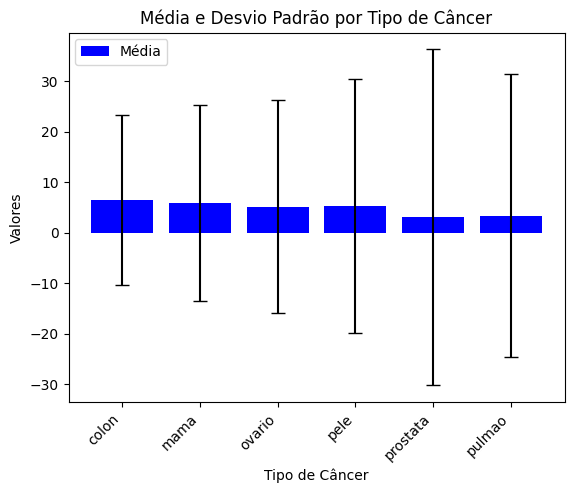

In [7]:
estatisticas_por_tipo_cancer = ordenado_por_y.groupby('Tipo_Cancer')['Y'].agg(['mean', 'std']).reset_index()

estatisticas_por_tipo_cancer = estatisticas_por_tipo_cancer.rename(columns={'mean': 'Media_Y', 'std': 'Desvio_Padrao_Y'})

fig, ax = plt.subplots()

ax.bar(estatisticas_por_tipo_cancer['Tipo_Cancer'], estatisticas_por_tipo_cancer['Media_Y'], color='blue', label='Média', yerr=estatisticas_por_tipo_cancer['Desvio_Padrao_Y'], capsize=5)

ax.set_xlabel('Tipo de Câncer')
ax.set_ylabel('Valores')
ax.set_title('Média e Desvio Padrão por Tipo de Câncer')

ax.legend()

plt.xticks(rotation=45, ha='right')

# Mostrar o gráfico
plt.show()

aqui gostaria de tirar uma conclusao que nos top 100 existem algumas combinaçõoes de drogas que aparecem repetidas e podiamos fazer em termos cientificos do que já existe. por exemplo das que aparecem repetidas a que tem maior média é a gen(...)- benz35, 2 drogas ainda experiemntais e  que atuam em target diferentes. algo interessante de explorar 

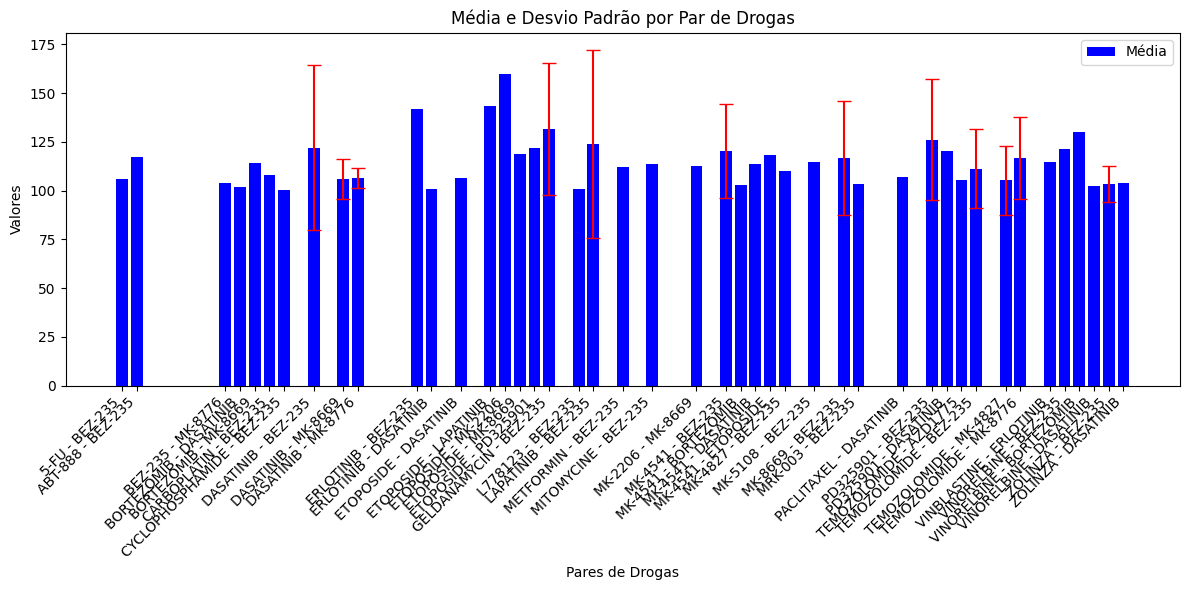

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que 'top_100_combinacoes' seja o seu DataFrame
# Substitua 'top_100_combinacoes' pelo nome real do seu DataFrame

# Ordenar por valores de 'Y'
ordenado_por_y = dataset.sort_values(by='Y', ascending=False)

# Selecionar as top 100 combinações de drogas
top_100_combinacoes = ordenado_por_y.head(100)

# Agrupar por pares de drogas e calcular média e desvio padrão
estatisticas_por_par_drogas = top_100_combinacoes.groupby(['Drug1_ID', 'Drug2_ID'])['Y'].agg(['mean', 'std']).reset_index()

# Filtrar apenas as combinações de drogas com média superior a 100
comb_drogas_filtradas = estatisticas_por_par_drogas[estatisticas_por_par_drogas['mean'] > 100]

# Criar um gráfico de barras com barras de erro
fig, ax = plt.subplots(figsize=(12, 6))

# Adicionar barras para a média
ax.bar(comb_drogas_filtradas.index, comb_drogas_filtradas['mean'], color='blue', label='Média', yerr=comb_drogas_filtradas['std'], capsize=5, ecolor='red')

# Adicionar rótulos apenas para as barras com média superior a 100
plt.xticks(comb_drogas_filtradas.index, comb_drogas_filtradas['Drug1_ID'] + ' - ' + comb_drogas_filtradas['Drug2_ID'], rotation=45, ha='right')

# Adicionar rótulos para todas as barras (com e sem média > 100)
ax.set_xlabel('Pares de Drogas')
ax.set_ylabel('Valores')
ax.set_title('Média e Desvio Padrão por Par de Drogas')

# Adicionar legenda
ax.legend()

# Mostrar o gráfico
plt.tight_layout()
plt.show()


In [14]:
#aquelas drogas que tem média de t superior a 100, nas top 100 combinações de drogas com y mais elevado;
#claro está que as que  tem std Nan É PQ APENAS APARECEM 1 VEZ ESSA COMBINAÇÃO
comb_drogas_filtradas

,Drug1_ID,Drug2_ID,mean,std
0,5-FU,BEZ-235,106.007192,NaN
1,ABT-888,BEZ-235,117.001279,NaN
7,BEZ-235,MK-8776,103.966988,NaN
8,BORTEZOMIB,DASATINIB,101.836038,NaN
9,BORTEZOMIB,MK-8669,114.179868,NaN
10,CARBOPLATIN,BEZ-235,107.973285,NaN
11,CYCLOPHOSPHAMIDE,BEZ-235,100.402495,NaN
13,DASATINIB,BEZ-235,122.025907,42.143039
15,DASATINIB,MK-8669,105.891362,10.203249
16,DASATINIB,MK-8776,106.290640,5.164066


agora vou fazr um grafico tipo correlação onde mostra a média do valor de y consoante cada combinação de droga tentando verificar valores mais elevados e mais baixos e com isso completar co info da literatura

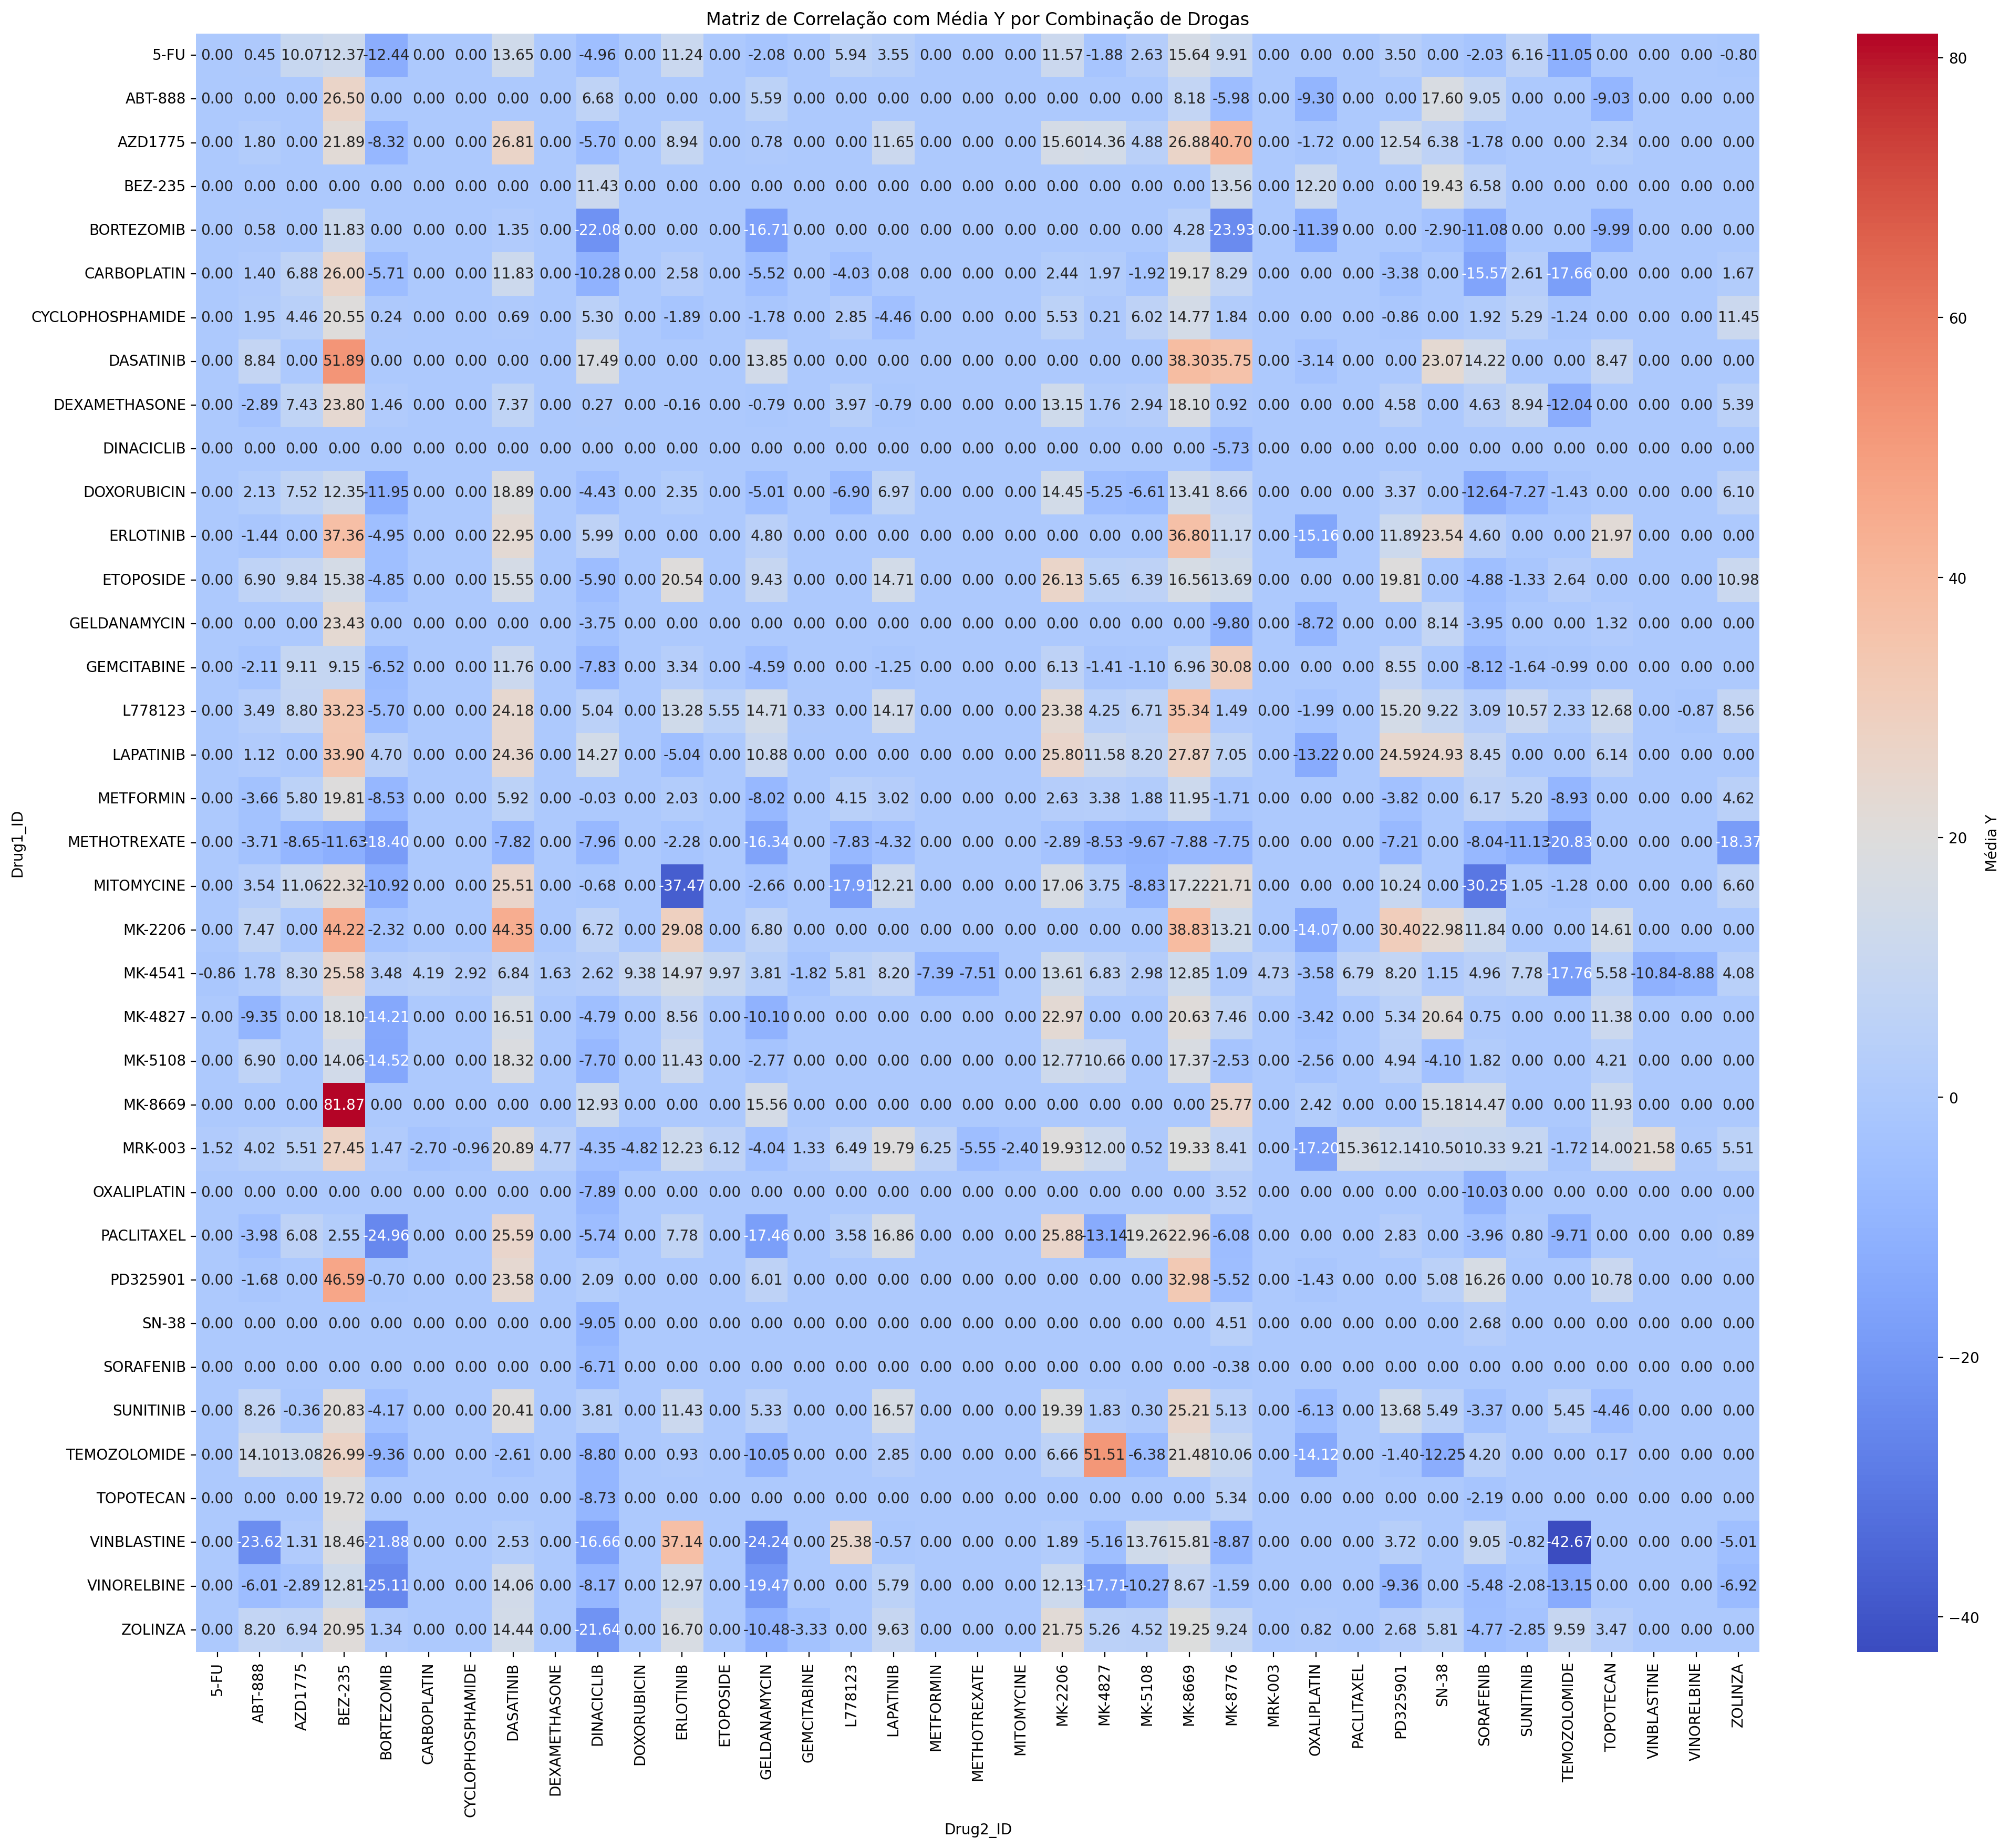

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que 'dataset' seja o seu DataFrame
# Substitua 'dataset' pelo nome real do seu DataFrame

# Calcular a média dos valores Y para cada combinação de drogas
media_por_combinacao = dataset.groupby(['Drug1_ID', 'Drug2_ID'])['Y'].mean().reset_index()

# Criar uma tabela de pivô para ter uma matriz de médias
matriz_media = media_por_combinacao.pivot(index='Drug1_ID', columns='Drug2_ID', values='Y').fillna(0)

# Criar um gráfico de correlação usando Seaborn
plt.figure(figsize=(24, 20), dpi=200)

sns.heatmap(matriz_media, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Média Y'})

# Adicionar rótulos e título
plt.xlabel('Drug2_ID')
plt.ylabel('Drug1_ID')
plt.title('Matriz de Correlação com Média Y por Combinação de Drogas')

plt.show()



Transformar o dataset para poder ser explorado, uma vez que iniciamente a coluna cell_line era uma lista com vários valores e, como posteriormente, iremos utilizar machine learning seria mais apropriado separar esses valores em features( que demos o nome de parametros).

nota- parameteros são caracteristicas geneticas/expressão genetiva das linhas celulares

In [4]:
#transfomar cada index da lista num parametro , parametros estes que seriam as features, num total de 8785 parametros
a=dataset["Cell_Line"].apply(pd.Series)
a.columns=[f"Parametro {i}" for i in range(a.shape[1])]
dataset=pd.concat([dataset,a], axis=1)
dataset=dataset.drop("Cell_Line", axis=1)
# dataset

Standerization da estrutura química de cada droga



In [18]:
drogas_unicas = list(OrderedDict.fromkeys(dataset['Drug1'])) #drug 1 ou drug 2 têm as mesmas drogas mas em ordem diferente
print(len(drogas_unicas))


37


In [6]:
#Nota que esta função foi nos dada na aula , e por isso, não é da nossa autoria
RDLogger.DisableLog('rdApp.*') # disable rdkit warnings

def standardize(smiles):
    # convert to mol object
    mol = Chem.MolFromSmiles(smiles)

    # avoid errors with invalid molecules
    if mol is None:
        return None

    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol)

    # if many fragments, get the "parent" (the actual mol we are interested in)
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger()
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

    # convert back to smiles
    uncharged_parent_clean_smiles = Chem.MolToSmiles(uncharged_parent_clean_mol)
    return uncharged_parent_clean_smiles

# apply the function to the SMILES column
resultados_stander=[]
for droga in drogas_unicas:
  resultado=standardize(droga)
  resultados_stander.append(resultado)
print(resultados_stander)
#standardized_data = dataset.copy().apply(lambda x: standardize(x['Drug1']), axis=1)
#standardized_data.head()

['O=c1[nH]cc(F)c(=O)[nH]1', 'CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1', 'C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-c1cccc(C(C)(C)O)n1', 'Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5ccccc5c4)ccc3ncc21', 'CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O', 'O=C(O)C1(C(=O)O)CCC1', 'O=P1(N(CCCl)CCCl)NCCCO1', 'Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CCO)CC2)n1', 'CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO', 'CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCCC3CCO)nc12', 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=O)CO)CC3OC1CC(N)C(O)C(C)O1', 'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1', 'COc1cc(C2c3cc4c(cc3C(OC3OC5COC(C)OC5C(O)C3O)C3COC(=O)C23)OCO4)cc(OC)c1O', 'COC1=C2CC(C)CC(OC)C(O)C(C)C=C(C)C(OC(N)=O)C(OC)C=CC=C(C)C(=O)NC(=CC1=O)C2=O', 'Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1', 'N#Cc1ccc(Cn2cncc2CN2CCN(c3cccc(Cl)c3)C(=O)C2)cc1', 'CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)o1', 'CN(C)C(=N)N=C(N)N', 'CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1', 'COC12C

Após ter a droga stander, procedemos ao calculo dos descritores e morgan fingerprints, para enriquecer o nosso dataset

In [7]:
#Nota que esta função foi nos dada na aula , e por isso, não é da nossa autoria

# 2D descriptors
def get_descriptors(smiles):
    feature_names = [x[0] for x in Descriptors._descList]
    try:
        mol = Chem.MolFromSmiles(smiles)
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(feature_names)
        # Deal with very large/inf values of the Ipc descriptor (https://github.com/rdkit/rdkit/issues/1527)
        # find position of Ipc
        pos = feature_names.index("Ipc")
        # calculate AvgIpc
        avg_ipc = Ipc(mol, avg=1)

        descriptors = list(calc.CalcDescriptors(mol))
        # replace Ipc with AvgIpc
        descriptors[pos] = avg_ipc
        descriptors = np.array(descriptors, dtype=np.float32)
        return descriptors
    except:
        # return np array of nans of size feature_names
        return np.empty(len(feature_names)) * np.nan


In [8]:
#Nota que esta função foi nos dada na aula , e por isso, não é da nossa autoria

# Morgan fingerprints

def get_morgan_fingerprints(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        morgan_fingerprints = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return np.array(morgan_fingerprints, np.float32)
    except:
        # return np array of nans of size feature_names
        return np.empty(1024) * np.nan

Optamos por juntar num dicionario as drogas stander, os descritores e as morgan para numa fase posterior conseguir acrescentar ao nosso dataset

In [9]:
dic={}
for droga in drogas_unicas:
  droga_padronizada=standardize(droga)
  descritores=get_descriptors(droga_padronizada)
  descritores=descritores.reshape(-1,1)
  scaler = StandardScaler()
  descritores_normalizados = scaler.fit_transform(descritores)
  descritores_final=descritores_normalizados.flatten()
  morgan=get_morgan_fingerprints(droga_padronizada)
  dic[droga]=(droga_padronizada,descritores_final,morgan)
# print(dic)

In [10]:
df = pd.DataFrame(dic.values(), columns=['Droga', 'Descritores',"morgan"])
df

,Droga,Descritores,morgan
0,O=c1[nH]cc(F)c(=O)[nH]1,"[0.21836044, -0.2581877, 0.21836044, -0.195501...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,"[0.00016604719, -0.2276598, 0.00016604719, -0....","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-...,"[-0.08822841, -0.20873016, -0.08822841, -0.197...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5...,"[-0.07906127, -0.17672954, -0.07906127, -0.171...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O,"[-0.0536565, -0.25853696, -0.0536565, -0.23332...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,O=C(O)C1(C(=O)O)CCC1,"[0.20747024, -0.33657113, 0.20747024, -0.25733...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
6,O=P1(N(CCCl)CCCl)NCCCO1,"[0.089380845, -0.34087682, 0.089380845, -0.247...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,"[-0.08836218, -0.22170371, -0.08836218, -0.217...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,"[-0.0017644739, -0.2577974, -0.0017644739, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCCC3CCO)nc12,"[-0.07648093, -0.21363837, -0.07648093, -0.213...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


Achamos interessante mostrar de uma forma mais visual as estruturas quimicas das drogas em estudo , por isso exploramos RDKik. Este é um conjunto de ferramentas de quimioinformática responsável por funções como manipulação, análise e visualização de estruturas químicas e respetivos dados.
Assim sendo, ao dataset original foi adicionada uma nova coluna ('ROMol') que irá armazenar o objecto da biblioteca de quimioinformática RDKit que representa cada molécula química.

In [11]:
#por segurança
ver_moleculas=df

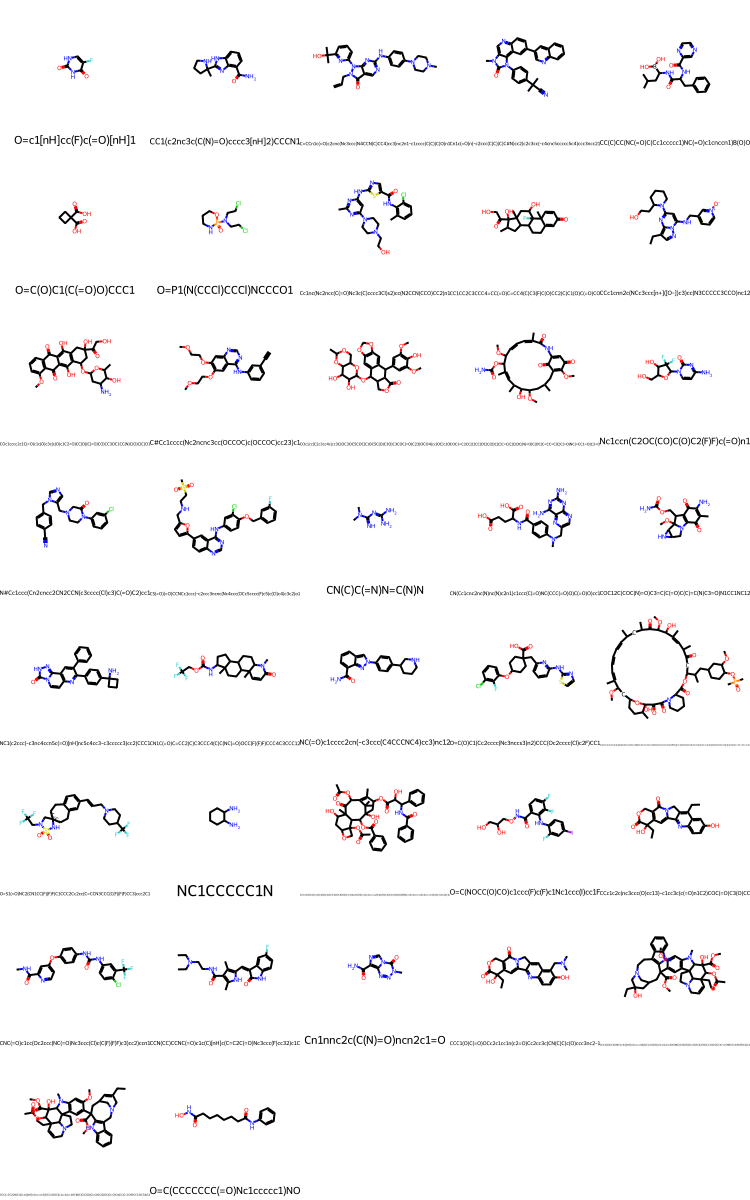

In [16]:
PandasTools.AddMoleculeColumnToFrame(ver_moleculas,'Droga')
[str(x) for x in  ver_moleculas.columns]
ver_moleculas = ver_moleculas[~ver_moleculas['ROMol'].isnull()]
PandasTools.FrameToGridImage(df,column= 'ROMol', molsPerRow=5,subImgSize=(150,150),legendsCol='Droga')


In [17]:
columns_to_map = ['Droga', 'Descritores',"morgan"]
for column in columns_to_map:
    mapping_dict = dict(zip(df['Droga'], df[column]))
    dataset[column+'d1'] = dataset['Drug1'].map(mapping_dict)
    dataset[column+'d2'] = dataset['Drug2'].map(mapping_dict)

# print(dataset)

In [18]:
a1=dataset["Descritoresd1"].apply(pd.Series)
a1.columns=[f"drug1 {x[0]}" for x in Descriptors._descList]
dataset=pd.concat([dataset,a1], axis=1)
dataset=dataset.drop("Descritoresd1", axis=1)
# dataset

In [19]:
b1=dataset["morgand1"].apply(pd.Series)
b1.columns=[f"morgan drug1 {i}" for i in range(b1.shape[1])]
dataset=pd.concat([dataset,b1], axis=1)
dataset=dataset.drop("morgand1", axis=1)

In [20]:
a2=dataset["Descritoresd2"].apply(pd.Series)
a2.columns=[f"drug2 {x[0]}" for x in Descriptors._descList]
dataset=pd.concat([dataset,a2], axis=1)
dataset=dataset.drop("Descritoresd2", axis=1)

In [21]:
b2=dataset["morgand2"].apply(pd.Series)
b2.columns=[f"morgan drug2 {i}" for i in range(b2.shape[1])]
dataset=pd.concat([dataset,b2], axis=1)
dataset=dataset.drop("morgand2", axis=1)
dataset

,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Drug1,Drug2,Parametro 0,Parametro 1,Parametro 2,Parametro 3,...,morgan drug2 1014,morgan drug2 1015,morgan drug2 1016,morgan drug2 1017,morgan drug2 1018,morgan drug2 1019,morgan drug2 1020,morgan drug2 1021,morgan drug2 1022,morgan drug2 1023
0,5-FU,ABT-888,A2058,7.693530,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.291146,5.040387,5.291146,0.908336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5-FU,ABT-888,A2780,7.778053,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.291146,5.040387,5.291146,0.908336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5-FU,ABT-888,A375,-1.198505,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.291146,5.040387,5.291146,0.908336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5-FU,ABT-888,A427,2.595684,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.291146,5.040387,5.291146,0.908336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5-FU,ABT-888,CAOV3,-5.139971,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,5.291146,5.040387,5.291146,0.908336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23047,ZOLINZA,TOPOTECAN,UACC62,10.223066,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,-0.188995,-0.198397,-0.188995,1.494725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23048,ZOLINZA,TOPOTECAN,UWB1289BRCA1,20.551627,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,-0.188995,-0.198397,-0.188995,1.494725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23049,ZOLINZA,TOPOTECAN,UWB1289,12.190316,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,-0.188995,-0.198397,-0.188995,1.494725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23050,ZOLINZA,TOPOTECAN,VCAP,23.438547,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,-0.188995,-0.198397,-0.188995,1.494725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Neste momento temos o dataset original + drug 1 e 2 stander + parametro + descritores + morgan.

Com referencia que os descritores ja foram normalizados para media 0 e desvio padrao 1, as morgan fingerprint deixamos estar com valor binario, e as cell line ja tem media 0 e desvio padrao 1.

Decidimos dar drop a colunas cujos valores nao eram numericos, sabendo também que nao temos valor NaN nas mesmas(pq isso seria errado).

In [22]:
print("valores nan presentes nos descritores e morgan fingerprint, respetivamente:", np.isnan(descritores).sum(), np.isnan(morgan).sum())

valores nan presentes nos descritores e morgan fingerprint, respetivamente: 0 0


In [23]:
tipos_de_dados = dataset.dtypes

# Identificando colunas não numéricas
colunas_nao_numericas = tipos_de_dados[tipos_de_dados != 'float64'][tipos_de_dados != 'int64'].index
dataset = dataset.drop(columns=colunas_nao_numericas)


O dataset apresentado tem apenas as colunas com valores numericos e o proximo passo será filtragem do mesmo.

In [24]:
dataset

,Y,Parametro 0,Parametro 1,Parametro 2,Parametro 3,Parametro 4,Parametro 5,Parametro 6,Parametro 7,Parametro 8,...,morgan drug2 1014,morgan drug2 1015,morgan drug2 1016,morgan drug2 1017,morgan drug2 1018,morgan drug2 1019,morgan drug2 1020,morgan drug2 1021,morgan drug2 1022,morgan drug2 1023
0,7.693530,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.778053,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.198505,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.595684,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-5.139971,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23047,10.223066,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23048,20.551627,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23049,12.190316,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23050,23.438547,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Selection

através do variance treshold ( superior a 0.15), iremos filtrar as nossas features. Se, por exemplo, uma determinada feature tive repetido o seu valor ao lonfo do dataset a mesma vai ser irrelevante logo podemos retirar.
ps: não houve razao cientifica para escolher 0.15

In [25]:
selector = VarianceThreshold(threshold=0.15)
selected_dataset = selector.fit_transform(dataset)
selected_columns = dataset.columns[selector.get_support()]
dataset_filtrado = pd.DataFrame(dataset, columns=selected_columns)
print("Shape do dataset após aplicar o Variance Threshold:", selected_dataset.shape)
print("Colunas selecionadas:", selected_columns)


Shape do dataset após aplicar o Variance Threshold: (23052, 8888)
Colunas selecionadas: Index(['Y', 'Parametro 0', 'Parametro 1', 'Parametro 2', 'Parametro 3',
       'Parametro 4', 'Parametro 5', 'Parametro 6', 'Parametro 7',
       'Parametro 8',
       ...
       'morgan drug2 801', 'morgan drug2 807', 'morgan drug2 831',
       'morgan drug2 875', 'morgan drug2 893', 'morgan drug2 904',
       'morgan drug2 926', 'morgan drug2 935', 'morgan drug2 974',
       'morgan drug2 1019'],
      dtype='object', length=8888)


In [26]:
dataset_filtrado

,Y,Parametro 0,Parametro 1,Parametro 2,Parametro 3,Parametro 4,Parametro 5,Parametro 6,Parametro 7,Parametro 8,...,morgan drug2 801,morgan drug2 807,morgan drug2 831,morgan drug2 875,morgan drug2 893,morgan drug2 904,morgan drug2 926,morgan drug2 935,morgan drug2 974,morgan drug2 1019
0,7.693530,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,7.778053,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,-1.198505,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2.595684,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,-5.139971,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23047,10.223066,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
23048,20.551627,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
23049,12.190316,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
23050,23.438547,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


Agora tivemos interesse por descobrir quais as features com maior variancia no dataset_filtrado.

In [28]:
selector = VarianceThreshold(threshold=0.15)
selected_dataset = selector.fit_transform(dataset)
selected_columns = dataset.columns[selector.get_support()]
print("Shape do dataset após aplicar o Variance Threshold:", selected_dataset.shape)
print("Colunas selecionadas:", selected_columns)

MemoryError: Unable to allocate 1.76 GiB for an array with shape (10226, 23052) and data type float64

## Análise da vaiável independente

Sabemos que

Y < -10 a interação entre as drogas é antagónica  ( A+B tem menos efeito do que A ou B isoladas)

-10 > Y > 10 interação likety aditiva (A+B efeito da droga A + afeito da droga B)

Y > 10 interação synergistic  (mais efeitos da droga A e B do que de forma individual)

Função para separar os Y no range que se encontram com o objetivo de fazer uma pieplot para mostrar visualmente a % de cada tipo de interação

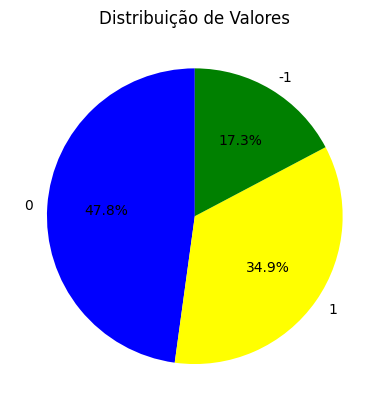

In [20]:
# Criar uma nova coluna chamada 'nova_coluna' com base nas condições
dataset['nova_coluna'] = np.where(dataset['Y'] <= -10, -1,
                                 np.where((dataset['Y'] > -10) & (dataset['Y'] < 10), 0, 1))


# Contar a ocorrência de cada valor na coluna 'nova_coluna'
contagem_valores = dataset['nova_coluna'].value_counts()

plt.pie(contagem_valores, labels=contagem_valores.index, autopct='%1.1f%%', startangle=90, colors=['blue', 'yellow', 'green'])
plt.title('Distribuição de Valores')
plt.show() 

Neste gráfico é possivel verificar que a maior parte dos valores de Y se encontra entre -10 e 10. Todavia nós tinhamos como objetido descobrir se há outliers, com o inutio de os eliminar.

Para isso realizamos o calculo dos outliers como demonstrado abaixo .

In [21]:
Q1 = dataset['Y'].quantile(0.25)
Q3 = dataset['Y'].quantile(0.75)
IQR = Q3 - Q1

# Identificar outliers
outliers = dataset[(dataset['Y'] < Q1 - 1.5 * IQR) | (dataset['Y'] > Q3 + 1.5 * IQR)]
outliers 

,Y,Parametro 0,Parametro 1,Parametro 2,Parametro 3,Parametro 4,Parametro 5,Parametro 6,Parametro 7,Parametro 8,...,morgan drug2 1015,morgan drug2 1016,morgan drug2 1017,morgan drug2 1018,morgan drug2 1019,morgan drug2 1020,morgan drug2 1021,morgan drug2 1022,morgan drug2 1023,nova_coluna
75,70.158169,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
91,55.291299,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
106,-73.138402,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
111,106.007192,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
133,52.485190,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22821,-54.421852,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
22831,71.114946,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
22873,57.501999,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
22987,50.720943,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Verificamos que tendo em conta as conta realizadas teriamos cerca de 1292 outliers. Face a isso decidimos realizar o gráfico abaixo para ter uma noção mais visual da distribuição dos valores de Y e respetiva frequencia.

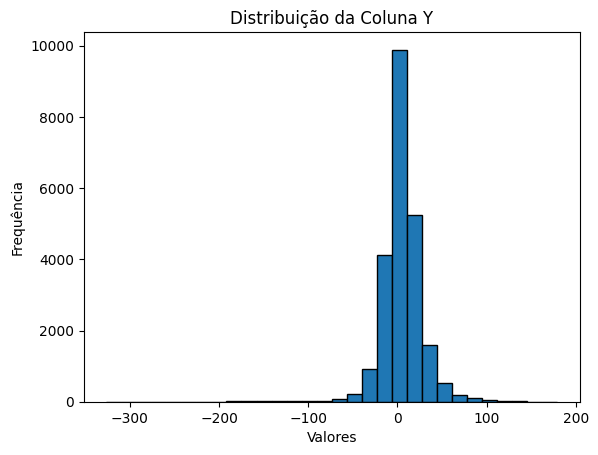

In [22]:
coluna_Y = 'Y'

# Crie um gráfico de distribuição
plt.hist(dataset[coluna_Y], bins=30, edgecolor='black')
plt.title('Distribuição da Coluna Y')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show() 

Aqui realemnte podemos verificar que a maior parte dos valores encontra-se entre -50 e 50 e, como tal decidimos considerar que os valores obtidos como outliers deveriam ser eliminados permitindo filtrar o dataset ao nivel das linhas.

Para ter um noção em percentagem conseguimos verificar que essa remoção corresponde a 4 % do dosso dataset.

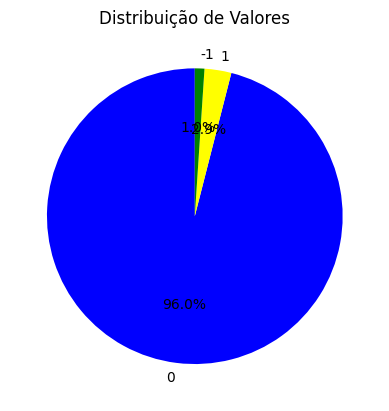

In [23]:
# Criar uma nova coluna chamada 'nova_coluna' com base nas condições
dataset['nova_coluna'] = np.where(dataset['Y'] <= -50, -1,
                                 np.where((dataset['Y'] > -50) & (dataset['Y'] < 50), 0, 1))

# Contar a ocorrência de cada valor na coluna 'nova_coluna'
contagem_valores = dataset['nova_coluna'].value_counts()

# Criar um gráfico de pizza
plt.pie(contagem_valores, labels=contagem_valores.index, autopct='%1.1f%%', startangle=90, colors=['blue', 'yellow', 'green'])
plt.title('Distribuição de Valores')
plt.show()


In [24]:
dataset_sem_outliers = dataset_filtrado.drop(outliers.index)
dataset_sem_outliers

,Y,Parametro 0,Parametro 1,Parametro 2,Parametro 3,Parametro 4,Parametro 5,Parametro 6,Parametro 7,Parametro 8,...,morgan drug2 801,morgan drug2 807,morgan drug2 831,morgan drug2 875,morgan drug2 893,morgan drug2 904,morgan drug2 926,morgan drug2 935,morgan drug2 974,morgan drug2 1019
0,7.693530,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,7.778053,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,-1.198505,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2.595684,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,-5.139971,5.291146,5.040387,5.291146,0.908336,2.514969,5.291146,5.291146,-1.492008,1.143195,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23047,10.223066,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
23048,20.551627,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
23049,12.190316,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
23050,23.438547,-0.188995,-0.198397,-0.188995,1.494725,-0.397619,-0.188995,-0.188995,-0.925171,-0.674146,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


Convertemos o dataset sem ouliers e filtrado num csv para guardar

In [25]:
dataset_sem_outliers.to_csv('dataset.csv', index=False)

Agora podemos ir buscar o dataset a partir daqui!